In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Principle Component Analysis

We can do principle component analysis to reduce the dimensionality across the repair outcomes to help identify the repair outcomes which result in the best seperation of the repair outcome profiles

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.data.load_dataset import load_lumc_outcomes
from src.config import get_common_barcodes

In [3]:
# takes about 6 minutes to load the data into memory
df = load_lumc_outcomes()
df.head()

/Users/colm/repos/MUSICian/src/data/load_dataset.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx[["fraction_per_barcode"]].sum(level=["Target", "Alias", "Gene", "Barcode"])


Normalised per Gene


fraction_per_barcode  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-1              0.001780   
                           0610009B22Rik-1              0.013351   
                           0610009B22Rik-1              0.002225   
                           0610009B22Rik-1              0.024477   

                                                lumc_category  del_len  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1  1bp insertion - A        0   
                           0610009B22Rik-1  1bp insertion - C        0   
                           0610009B22Rik-1  1bp insertion - G        0   
                           0610009B22Rik-1  1bp insertion - T        0   
                           0610009B22Rik-1     >1bp insertion        0   

                                            countEvents  
Target Alias Gene          Barcode                       
T1     MB01  0610009B22Rik 0610009B22Rik-1          126  
                           0610009B22Rik-1            4  
                           0610009B22Rik-1           30  
                           0610009B22Rik-1            5  
                           0610009B22Rik-1           55

In [4]:
test = pd.read_csv(get_common_barcodes(), sep="\t")
test["Filtered"].unique()

array([0, 1, 3, 2, 4, 5])

In [5]:
filtered_barcodes = pd.read_csv(get_common_barcodes(), sep="\t")
filtered_barcodes.head()

,Target,Alias,Gene,Barcode,Filtered,Counts,Corr_Within,Corr_Between,log10Count
0,T1,MB01,0610009B22Rik,0610009B22Rik-1,0,2247.0,0.952007,0.910326,3.351603
1,T1,MB01,0610009B22Rik,0610009B22Rik-2,0,2792.0,0.962390,0.939419,3.445915
2,T1,MB01,0610009B22Rik,0610009B22Rik-3,0,3907.0,0.966884,0.952470,3.591843
3,T1,MB01,0610009B22Rik,0610009B22Rik-4,0,3757.0,0.968739,0.955281,3.574841
4,T1,MB01,0610009B22Rik,0610009B22Rik-5,0,2549.0,0.965979,0.959352,3.406370


In [6]:
kept_indexes = pd.MultiIndex.from_frame(filtered_barcodes[filtered_barcodes["Filtered"] == 0][["Target", "Alias", "Gene", "Barcode"]])
kept_indexes.to_list()[:5]

[('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-1'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-2'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-3'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-4'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-5')]

### Do our categories capture the variation in repair outcomes between target sites?

Run PCA analysis on Target Site/Replicate/gRNA x Outcomes 

In [87]:
target_site_to_test = "T2"

In [88]:
df.head()

fraction_per_barcode  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-1              0.001780   
                           0610009B22Rik-1              0.013351   
                           0610009B22Rik-1              0.002225   
                           0610009B22Rik-1              0.024477   

                                                lumc_category  del_len  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1  1bp insertion - A        0   
                           0610009B22Rik-1  1bp insertion - C        0   
                           0610009B22Rik-1  1bp insertion - G        0   
                           0610009B22Rik-1  1bp insertion - T        0   
                           0610009B22Rik-1     >1bp insertion        0   

                                            countEvents  
Target Alias Gene          Barcode                       
T1     MB01  0610009B22Rik 0610009B22Rik-1          126  
                           0610009B22Rik-1            4  
                           0610009B22Rik-1           30  
                           0610009B22Rik-1            5  
                           0610009B22Rik-1           55

In [89]:
df.groupby(["Alias", "Barcode"]).sum().head()

fraction_per_barcode  del_len  countEvents
Alias Barcode                                                    
MB01  0610009B22Rik-1                   1.0      529         2247
      0610009B22Rik-2                   1.0      719         2792
      0610009B22Rik-3                   1.0      779         3907
      0610009B22Rik-4                   1.0      609         3757
      0610009B22Rik-5                   1.0      529         2549

In [90]:
X = df.reset_index()
X.head()

,Target,Alias,Gene,Barcode,fraction_per_barcode,lumc_category,del_len,countEvents
0,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.056075,1bp insertion - A,0,126
1,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.001780,1bp insertion - C,0,4
2,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.013351,1bp insertion - G,0,30
3,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.002225,1bp insertion - T,0,5
4,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.024477,>1bp insertion,0,55


In [91]:
X["Feature"] = X["lumc_category"] + ", " + X["del_len"].astype(str)

In [92]:
X.groupby(["Alias", "Barcode"]).size().groupby(["Alias"]).size()

Alias
MB01    89414
MB02    89423
MB03    89492
MB04    89481
MB05    89477
MB06    89478
dtype: int64

In [93]:
X = X.pivot(index=["Target", "Alias", "Gene", "Barcode"], columns=["Feature"], values="fraction_per_barcode").fillna(0)
X.head()

Feature                                     1bp insertion - A, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-2              0.061605   
                           0610009B22Rik-3              0.048887   
                           0610009B22Rik-4              0.074528   
                           0610009B22Rik-5              0.090231   

Feature                                     1bp insertion - C, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.001780   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.000768   
                           0610009B22Rik-4              0.005323   
                           0610009B22Rik-5              0.006277   

Feature                                     1bp insertion - G, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.013351   
                           0610009B22Rik-2              0.002865   
                           0610009B22Rik-3              0.009726   
                           0610009B22Rik-4              0.007453   
                           0610009B22Rik-5              0.002354   

Feature                                     1bp insertion - T, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.002225   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.010238   
                           0610009B22Rik-4              0.010647   
                           0610009B22Rik-5              0.000000   

Feature                                     >1bp insertion, 0  \
Target Alias Gene          Barcode                              
T1     MB01  0610009B22Rik 0610009B22Rik-1           0.024477   
                           0610009B22Rik-2           0.032235   
                           0610009B22Rik-3           0.016381   
                           0610009B22Rik-4           0.033537   
                           0610009B22Rik-5           0.014123   

Feature                                     Deletion 0bp microhomology, 1  \
Target Alias Gene          Barcode                                          
T1     MB01  0610009B22Rik 0610009B22Rik-1                       0.000890   
                           0610009B22Rik-2                       0.001433   
                           0610009B22Rik-3                       0.000000   
                           0610009B22Rik-4                       0.000000   
                           0610009B22Rik-5                       0.000000   

Feature                                     Deletion 0bp microhomology, 10  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.010236   
                           0610009B22Rik-2                        0.005014   
                           0610009B22Rik-3                        0.000000   
                           0610009B22Rik-4                        0.000000   
                           0610009B22Rik-5                        0.000785   

Feature                                     Deletion 0bp microhomology, 11  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.005785   
                           0610009B22Rik-2                        0.003223   
                           0610009B22Rik-3                        0.005375   
                           0610009B22Rik-4                        0.006654   
                           0610009B22Rik-5                        0.003531   

Fe

In [94]:
X = X.loc[kept_indexes]
X.shape

(519536, 105)

In [95]:
X.sum(axis=1)

Target  Alias  Gene           Barcode        
T1      MB01   0610009B22Rik  0610009B22Rik-1    1.0
                              0610009B22Rik-2    1.0
                              0610009B22Rik-3    1.0
                              0610009B22Rik-4    1.0
                              0610009B22Rik-5    1.0
                                                ... 
T3      MB06   mei-04         Mei4-1             1.0
                              Mei4-2             1.0
                              Mei4-3             1.0
                              Mei4-4             1.0
                              Mei4-5             1.0
Length: 519536, dtype: float64

In [96]:
sparseness = (X == 0).sum().sum() / (X.shape[0] * X.shape[1])
print("The matrix is {:.3f} sparse. Could this be a problem for PCA?".format(sparseness))

The matrix is 0.575 sparse. Could this be a problem for PCA?


In [97]:
X.head()

Feature                                     1bp insertion - A, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-2              0.061605   
                           0610009B22Rik-3              0.048887   
                           0610009B22Rik-4              0.074528   
                           0610009B22Rik-5              0.090231   

Feature                                     1bp insertion - C, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.001780   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.000768   
                           0610009B22Rik-4              0.005323   
                           0610009B22Rik-5              0.006277   

Feature                                     1bp insertion - G, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.013351   
                           0610009B22Rik-2              0.002865   
                           0610009B22Rik-3              0.009726   
                           0610009B22Rik-4              0.007453   
                           0610009B22Rik-5              0.002354   

Feature                                     1bp insertion - T, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.002225   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.010238   
                           0610009B22Rik-4              0.010647   
                           0610009B22Rik-5              0.000000   

Feature                                     >1bp insertion, 0  \
Target Alias Gene          Barcode                              
T1     MB01  0610009B22Rik 0610009B22Rik-1           0.024477   
                           0610009B22Rik-2           0.032235   
                           0610009B22Rik-3           0.016381   
                           0610009B22Rik-4           0.033537   
                           0610009B22Rik-5           0.014123   

Feature                                     Deletion 0bp microhomology, 1  \
Target Alias Gene          Barcode                                          
T1     MB01  0610009B22Rik 0610009B22Rik-1                       0.000890   
                           0610009B22Rik-2                       0.001433   
                           0610009B22Rik-3                       0.000000   
                           0610009B22Rik-4                       0.000000   
                           0610009B22Rik-5                       0.000000   

Feature                                     Deletion 0bp microhomology, 10  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.010236   
                           0610009B22Rik-2                        0.005014   
                           0610009B22Rik-3                        0.000000   
                           0610009B22Rik-4                        0.000000   
                           0610009B22Rik-5                        0.000785   

Feature                                     Deletion 0bp microhomology, 11  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.005785   
                           0610009B22Rik-2                        0.003223   
                           0610009B22Rik-3                        0.005375   
                           0610009B22Rik-4                        0.006654   
                           0610009B22Rik-5                        0.003531   

Fe

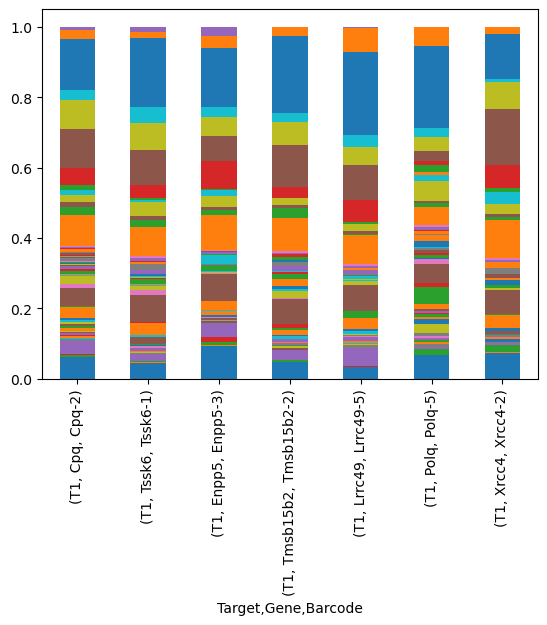

In [98]:
examples = X.xs("MB01", level="Alias").index.to_series().sample(5)
ax = pd.concat((X.xs("MB01", level="Alias").loc[examples],
    X.xs("MB01", level="Alias").loc[[("T1", "Polq", "Polq-5"), ("T1", "Xrcc4", "Xrcc4-2")],]), axis=0).fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()


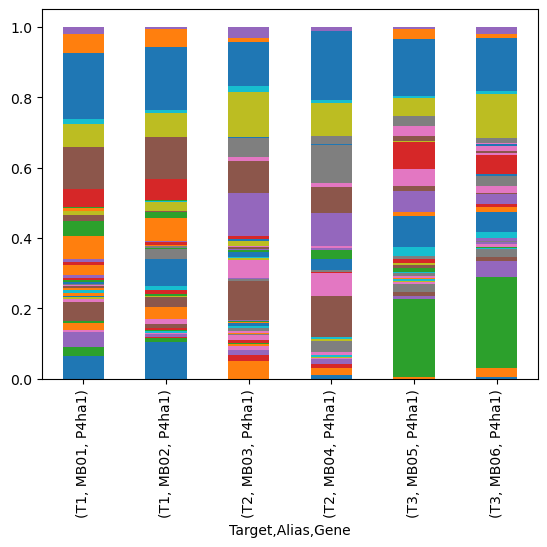

In [99]:
idx = pd.IndexSlice
ax = X.loc[idx[:,:,:,'P4ha1-4']].fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()

In [100]:
X.shape

(519536, 105)

In [101]:
X = X.xs(target_site_to_test, level="Target")

In [102]:
# X.hist(sharex=False, sharey=False, figsize=(15,15))
# samples_to_pairplot = X.iloc[:,:10].sample(10000)
# samples_to_pairplot["Alias"] = X.loc[samples_to_pairplot.index].index.get_level_values("Alias").to_list()
# sns.pairplot(samples_to_pairplot, hue="Alias", palette="Paired", hue_order=["MB0" + str(i) for i in range(1,7)])


In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardise the data
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_st = pd.DataFrame(X_st, index=X.index, columns=X.columns)
X_st.head()

Feature                              1bp insertion - A, 0  \
Alias Gene          Barcode                                 
MB03  0610009B22Rik 0610009B22Rik-1              0.003777   
                    0610009B22Rik-2             -0.022100   
                    0610009B22Rik-3             -0.022993   
                    0610009B22Rik-4             -0.182457   
                    0610009B22Rik-5             -0.333384   

Feature                              1bp insertion - C, 0  \
Alias Gene          Barcode                                 
MB03  0610009B22Rik 0610009B22Rik-1              0.163560   
                    0610009B22Rik-2             -0.021838   
                    0610009B22Rik-3              0.033286   
                    0610009B22Rik-4              0.175071   
                    0610009B22Rik-5             -0.299217   

Feature                              1bp insertion - G, 0  \
Alias Gene          Barcode                                 
MB03  0610009B22Rik 0610009B22Rik-1             -0.675530   
                    0610009B22Rik-2              0.233206   
                    0610009B22Rik-3              0.005219   
                    0610009B22Rik-4             -0.317192   
                    0610009B22Rik-5             -0.273596   

Feature                              1bp insertion - T, 0  >1bp insertion, 0  \
Alias Gene          Barcode                                                    
MB03  0610009B22Rik 0610009B22Rik-1             -0.348447           0.150641   
                    0610009B22Rik-2              0.083231           0.482283   
                    0610009B22Rik-3             -0.805211           0.570463   
                    0610009B22Rik-4              0.782444           0.234798   
                    0610009B22Rik-5             -0.164312           0.380780   

Feature                              Deletion 0bp microhomology, 1  \
Alias Gene          Barcode                                          
MB03  0610009B22Rik 0610009B22Rik-1                      -0.267948   
                    0610009B22Rik-2                      -0.267948   
                    0610009B22Rik-3                       0.025020   
                    0610009B22Rik-4                      -0.036626   
                    0610009B22Rik-5                      -0.267948   

Feature                              Deletion 0bp microhomology, 10  \
Alias Gene          Barcode                                           
MB03  0610009B22Rik 0610009B22Rik-1                       -0.494709   
                    0610009B22Rik-2                       -0.271049   
                    0610009B22Rik-3                       -0.600150   
                    0610009B22Rik-4                       -0.464280   
                    0610009B22Rik-5                       -0.336100   

Feature                              Deletion 0bp microhomology, 11  \
Alias Gene          Barcode                                           
MB03  0610009B22Rik 0610009B22Rik-1                        0.021943   
                    0610009B22Rik-2                       -0.292964   
                    0610009B22Rik-3                       -0.091934   
                    0610009B22Rik-4                       -0.561745   
                    0610009B22Rik-5                       -0.561745   

Feature                              Deletion 0bp microhomology, 12  \
Alias Gene          Barcode                                           
MB03  0610009B22Rik 0610009B22Rik-1                        3.672954   
                    0610009B22Rik-2                       -0.449049   
                    0610009B22Rik-3                        0.322106   
                    0610009B22Rik-4                       -0.533565   
                    0610009B22Rik-5                       -0.627266   

Feature                              Deletion 0bp microhomology, 13  ...  \
Alias Gene          Barcode                                          ...   
MB03  0610009B22Ri

In [104]:
X_st.shape

(174510, 105)

In [105]:
# fit the PCA model
pca_out = PCA().fit(X_st)

# get the component variance
print("Component variance")
print(pca_out.explained_variance_ratio_)

# Cumulative proportion of variance 
print("Cumulative proportion of variance explained")
cum_variance = np.cumsum(pca_out.explained_variance_ratio_)
print(np.cumsum(pca_out.explained_variance_ratio_))

Component variance
[1.62319787e-02 1.24607329e-02 1.19058725e-02 1.18326588e-02
 1.16623100e-02 1.15564160e-02 1.15166863e-02 1.14506993e-02
 1.14298934e-02 1.14293235e-02 1.13916696e-02 1.13823515e-02
 1.13670334e-02 1.13436420e-02 1.13390710e-02 1.13210083e-02
 1.12992059e-02 1.12764427e-02 1.12611843e-02 1.12374421e-02
 1.12294583e-02 1.12018609e-02 1.11915502e-02 1.11795723e-02
 1.11760128e-02 1.11624708e-02 1.11498840e-02 1.11353069e-02
 1.11279539e-02 1.11109556e-02 1.10860324e-02 1.10833115e-02
 1.10705643e-02 1.10527540e-02 1.10368617e-02 1.10311701e-02
 1.10043010e-02 1.09928609e-02 1.09818344e-02 1.09745403e-02
 1.09716236e-02 1.09497357e-02 1.09371881e-02 1.09210522e-02
 1.09142470e-02 1.09014115e-02 1.08931513e-02 1.08711782e-02
 1.08652349e-02 1.08558552e-02 1.08503418e-02 1.08456602e-02
 1.08164089e-02 1.08104252e-02 1.07996998e-02 1.07835527e-02
 1.07781407e-02 1.07681812e-02 1.07660300e-02 1.07497326e-02
 1.07416977e-02 1.07194681e-02 1.07172880e-02 1.06967790e-02
 1.06

0.040598584047492337

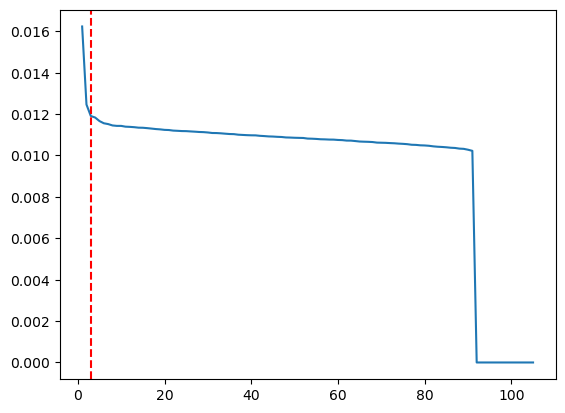

In [106]:
# scree plot

MANUALLY_SELECTED_THRESHOLD = 3
sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
np.sum(pca_out.explained_variance_ratio_[:MANUALLY_SELECTED_THRESHOLD])

In [107]:
kaisers_rule = sum(pca_out.explained_variance_ > 1)
kaisers_rule

48

62


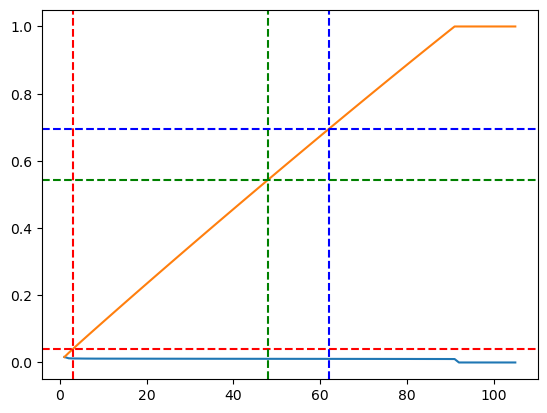

In [108]:
VARIANCE_TO_EXPLAIN = .7

var_cumsum = np.cumsum(pca_out.explained_variance_ratio_)
variance_explained_by_num_pcs = sum(var_cumsum < VARIANCE_TO_EXPLAIN)
print(variance_explained_by_num_pcs)

sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
sns.lineplot(y=var_cumsum, x=np.arange(pca_out.n_components_) + 1)

plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
plt.axhline(var_cumsum[MANUALLY_SELECTED_THRESHOLD-1], ls="--", color="red")

plt.axvline(kaisers_rule, ls="--", color="green")
plt.axhline(var_cumsum[kaisers_rule-1], ls="--", color="green")

plt.axvline(variance_explained_by_num_pcs, ls="--", color="blue")
plt.axhline(var_cumsum[variance_explained_by_num_pcs-1], ls="--", color="blue")

In [109]:
principle_components = pca_out.transform(X_st)
components_names = ["PC" + str(i+1) for i in range(principle_components.shape[1])]
pca_df = pd.DataFrame(principle_components, columns=components_names)
pca_df.shape

(174510, 105)

In [110]:
principle_components[:,0].shape

(174510,)

In [111]:
X.index.get_level_values("Alias")

Index(['MB03', 'MB03', 'MB03', 'MB03', 'MB03', 'MB03', 'MB03', 'MB03', 'MB03',
       'MB03',
       ...
       'MB04', 'MB04', 'MB04', 'MB04', 'MB04', 'MB04', 'MB04', 'MB04', 'MB04',
       'MB04'],
      dtype='object', name='Alias', length=174510)

Text(37.597222222222214, 0.5, 'PC2 - 0.012')

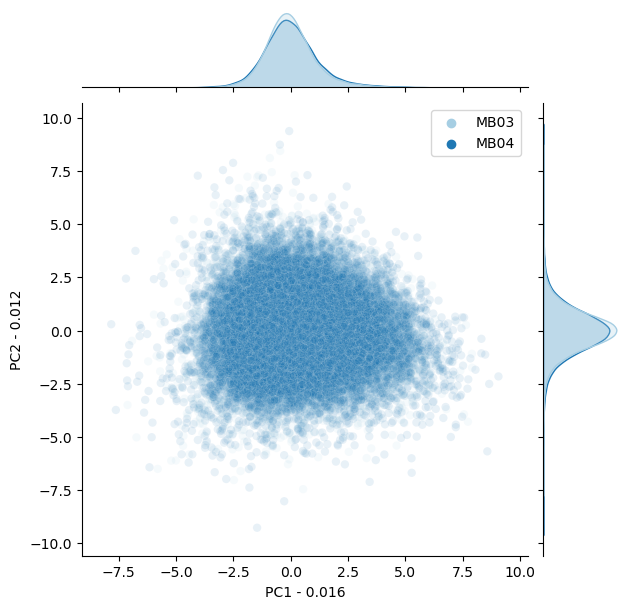

In [112]:
h = sns.jointplot(x = principle_components[:,0], y = principle_components[:,1], hue=X.index.get_level_values("Alias").to_list(), palette="Paired", alpha=.1)
h.ax_joint.set_xlabel('PC1 - {:.3f}'.format(pca_out.explained_variance_ratio_[0]))
h.ax_joint.set_ylabel('PC2 - {:.3f}'.format(pca_out.explained_variance_ratio_[1]))

<AxesSubplot:>

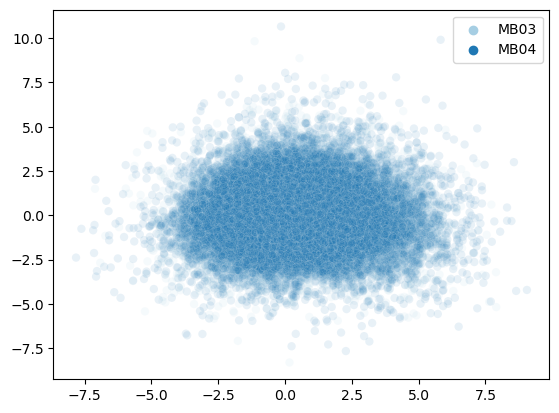

In [113]:
sns.scatterplot(x = principle_components[:,0], y = principle_components[:,2], hue=X.index.get_level_values("Alias").to_list(), palette="Paired", alpha=.1)

In [114]:
# samples_to_pairplot = pca_df.iloc[:,:10].sample(10000)
# samples_to_pairplot["Alias"] = X.iloc[samples_to_pairplot.index].index.get_level_values("Alias").to_list()
# sns.pairplot(samples_to_pairplot, hue="Alias", palette="Paired", hue_order=["MB0" + str(i) for i in range(1,7)])

In [115]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+"{:.3f}".format(pca_out.explained_variance_ratio_[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_st.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC10.016,PC20.012,PC30.012,PC40.012,PC50.012,PC60.012,PC70.012,PC80.011,PC90.011,PC100.011,...,PC960.000,PC970.000,PC980.000,PC990.000,PC1000.000,PC1010.000,PC1020.000,PC1030.000,PC1040.000,PC1050.000
variable,,,,,,,,,,,,,,,,,,,,,
"1bp insertion - A, 0",0.086687,-0.043175,-0.042383,-0.002348,0.117650,0.048745,0.011629,-0.025150,0.091827,-0.011978,...,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"1bp insertion - C, 0",0.374137,-0.032684,-0.137276,0.049919,0.083351,-0.096346,-0.059630,0.003384,-0.025639,-0.111419,...,2.637787e-17,1.927255e-17,1.696952e-17,5.005109e-18,1.012766e-17,-1.115432e-18,-7.815263e-18,4.470459e-17,-1.483965e-17,-2.489127e-17
"1bp insertion - G, 0",0.045822,0.021649,-0.055110,0.050270,0.004682,0.085647,0.071025,0.038162,0.070105,0.131269,...,-4.279358e-17,4.850754e-17,-3.942869e-17,5.708991e-17,-3.506007e-17,3.095925e-17,6.448364e-17,-3.883680e-17,-2.913976e-17,2.227944e-17
"1bp insertion - T, 0",0.085123,-0.029260,-0.072093,0.103233,0.056392,0.049125,-0.133595,0.095510,0.096831,-0.130546,...,1.354182e-16,3.760261e-17,3.879613e-18,5.118653e-17,5.543705e-17,-1.988416e-17,-2.915522e-17,5.560343e-17,1.007879e-16,-2.827898e-17
">1bp insertion, 0",0.079373,0.099502,0.076758,0.057838,-0.051266,0.222843,-0.118693,0.207735,-0.081960,0.045707,...,-7.094337e-17,2.978255e-17,-4.072934e-17,6.038250e-17,6.512074e-17,-2.041268e-17,-2.670862e-17,4.170297e-17,-5.745413e-17,2.734878e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Homology Directed Repair, 0",-0.586483,-0.515021,-0.245103,0.041104,-0.078999,-0.027886,0.028855,0.145598,-0.064556,-0.059328,...,1.937749e-17,1.417360e-17,7.947500e-18,5.358089e-18,9.177016e-18,-2.515990e-18,-9.329992e-19,1.649183e-17,4.547115e-18,-5.156200e-18
"Large Deletion, 0",-0.001025,0.053231,-0.044804,0.055261,0.057409,0.209363,-0.035545,0.170400,0.000256,0.315341,...,-1.718959e-16,-4.751510e-17,1.986469e-17,-9.028816e-17,-2.215922e-17,-3.375523e-17,-4.861452e-17,7.448283e-17,-5.905709e-17,-1.254324e-18
"Tandem Duplication plus, 0",-0.015510,-0.003323,-0.005950,-0.042473,-0.094706,0.017778,-0.214104,0.121919,0.014646,0.127252,...,-4.407582e-17,1.591383e-17,6.075602e-17,3.081553e-17,-7.768304e-17,4.659950e-17,4.110212e-17,-2.332573e-17,-8.745656e-17,1.359538e-17


In [116]:
pca_scores = pca_out.transform(X_st)
pca_scores_df = pd.DataFrame(pca_scores, columns=pc_list, index=X_st.index)
pca_scores_df.head()

PC10.016  PC20.012  PC30.012  PC40.012  \
Alias Gene          Barcode                                                   
MB03  0610009B22Rik 0610009B22Rik-1 -1.085033  0.734518 -1.345939  0.672044   
                    0610009B22Rik-2  0.457274 -0.218191 -0.023403  0.087684   
                    0610009B22Rik-3  0.405670 -0.476074  0.446198  0.060270   
                    0610009B22Rik-4 -0.273782 -0.268621 -0.003060 -0.378125   
                    0610009B22Rik-5  0.281975  0.191878 -0.247448 -0.142886   

                                     PC50.012  PC60.012  PC70.012  PC80.011  \
Alias Gene          Barcode                                                   
MB03  0610009B22Rik 0610009B22Rik-1  0.221128 -1.059438 -0.290917  1.159777   
                    0610009B22Rik-2 -0.785421  0.626431 -0.881728  0.156907   
                    0610009B22Rik-3  0.167470 -0.439436  0.579560 -0.222648   
                    0610009B22Rik-4  1.029088 -0.254252  0.106239 -0.225397   
                    0610009B22Rik-5  0.125118 -0.171898  0.112816 -0.701042   

                                     PC90.011  PC100.011  ...     PC960.000  \
Alias Gene          Barcode                               ...                 
MB03  0610009B22Rik 0610009B22Rik-1  0.443287  -0.291965  ... -9.736447e-16   
                    0610009B22Rik-2  0.465140   0.091896  ...  5.011232e-16   
                    0610009B22Rik-3 -0.315907   0.141645  ... -6.679677e-16   
                    0610009B22Rik-4 -1.130462  -0.891344  ...  6.779059e-16   
                    0610009B22Rik-5  0.348895   0.937505  ...  7.197557e-16   

                                        PC970.000     PC980.000     PC990.000  \
Alias Gene          Barcode                                                     
MB03  0610009B22Rik 0610009B22Rik-1 -7.387829e-16 -4.443374e-16 -3.795962e-16   
                    0610009B22Rik-2  2.485825e-16  9.916098e-17 -6.987953e-16   
                    0610009B22Rik-3 -2.056584e-16 -3.855149e-16  2.071580e-16   
                    0610009B22Rik-4  5.797098e-16  4.417341e-16  2.533426e-16   
                    0610009B22Rik-5  7.276899e-16  6.273419e-17  1.479553e-16   

                                       PC1000.000    PC1010.000    PC1020.000  \
Alias Gene          Barcode                                                     
MB03  0610009B22Rik 0610009B22Rik-1  2.822447e-16  8.037282e-16  5.090046e-17   
                    0610009B22Rik-2  6.782486e-16 -4.381830e-16 -2.026801e-16   
                    0610009B22Rik-3  1.586576e-16 -8.885638e-17 -3.034195e-16   
                    0610009B22Rik-4  1.377283e-16 -2.161716e-16  2.891246e-16   
                    0610009B22Rik-5  2.867944e-16  3.336211e-16 -6.978920e-17   

                                       PC1030.000    PC1040.000    PC1050.000  
Alias Gene          Barcode                                                    
MB03  0610009B22Rik 0610009B22Rik-1 -8.007333e-16 -2.129269e-16  5.915654e-16  
                    0610009B22Rik-2  2.624636e-16  2.423575e-17  1.513837e-16  
                    0610009B22Rik-3 -8.753168e-17 -5.286810e-16  4.358876e-16  
                    0610009B22Rik-4  3.964055e-16  4.585590e-16 -3.623582e-16  
                    0610009B22Rik-5 -2.643950e-16  4.140767e-16 -1.382448e-16  

[5 rows x 105 columns]

<AxesSubplot:ylabel='variable'>

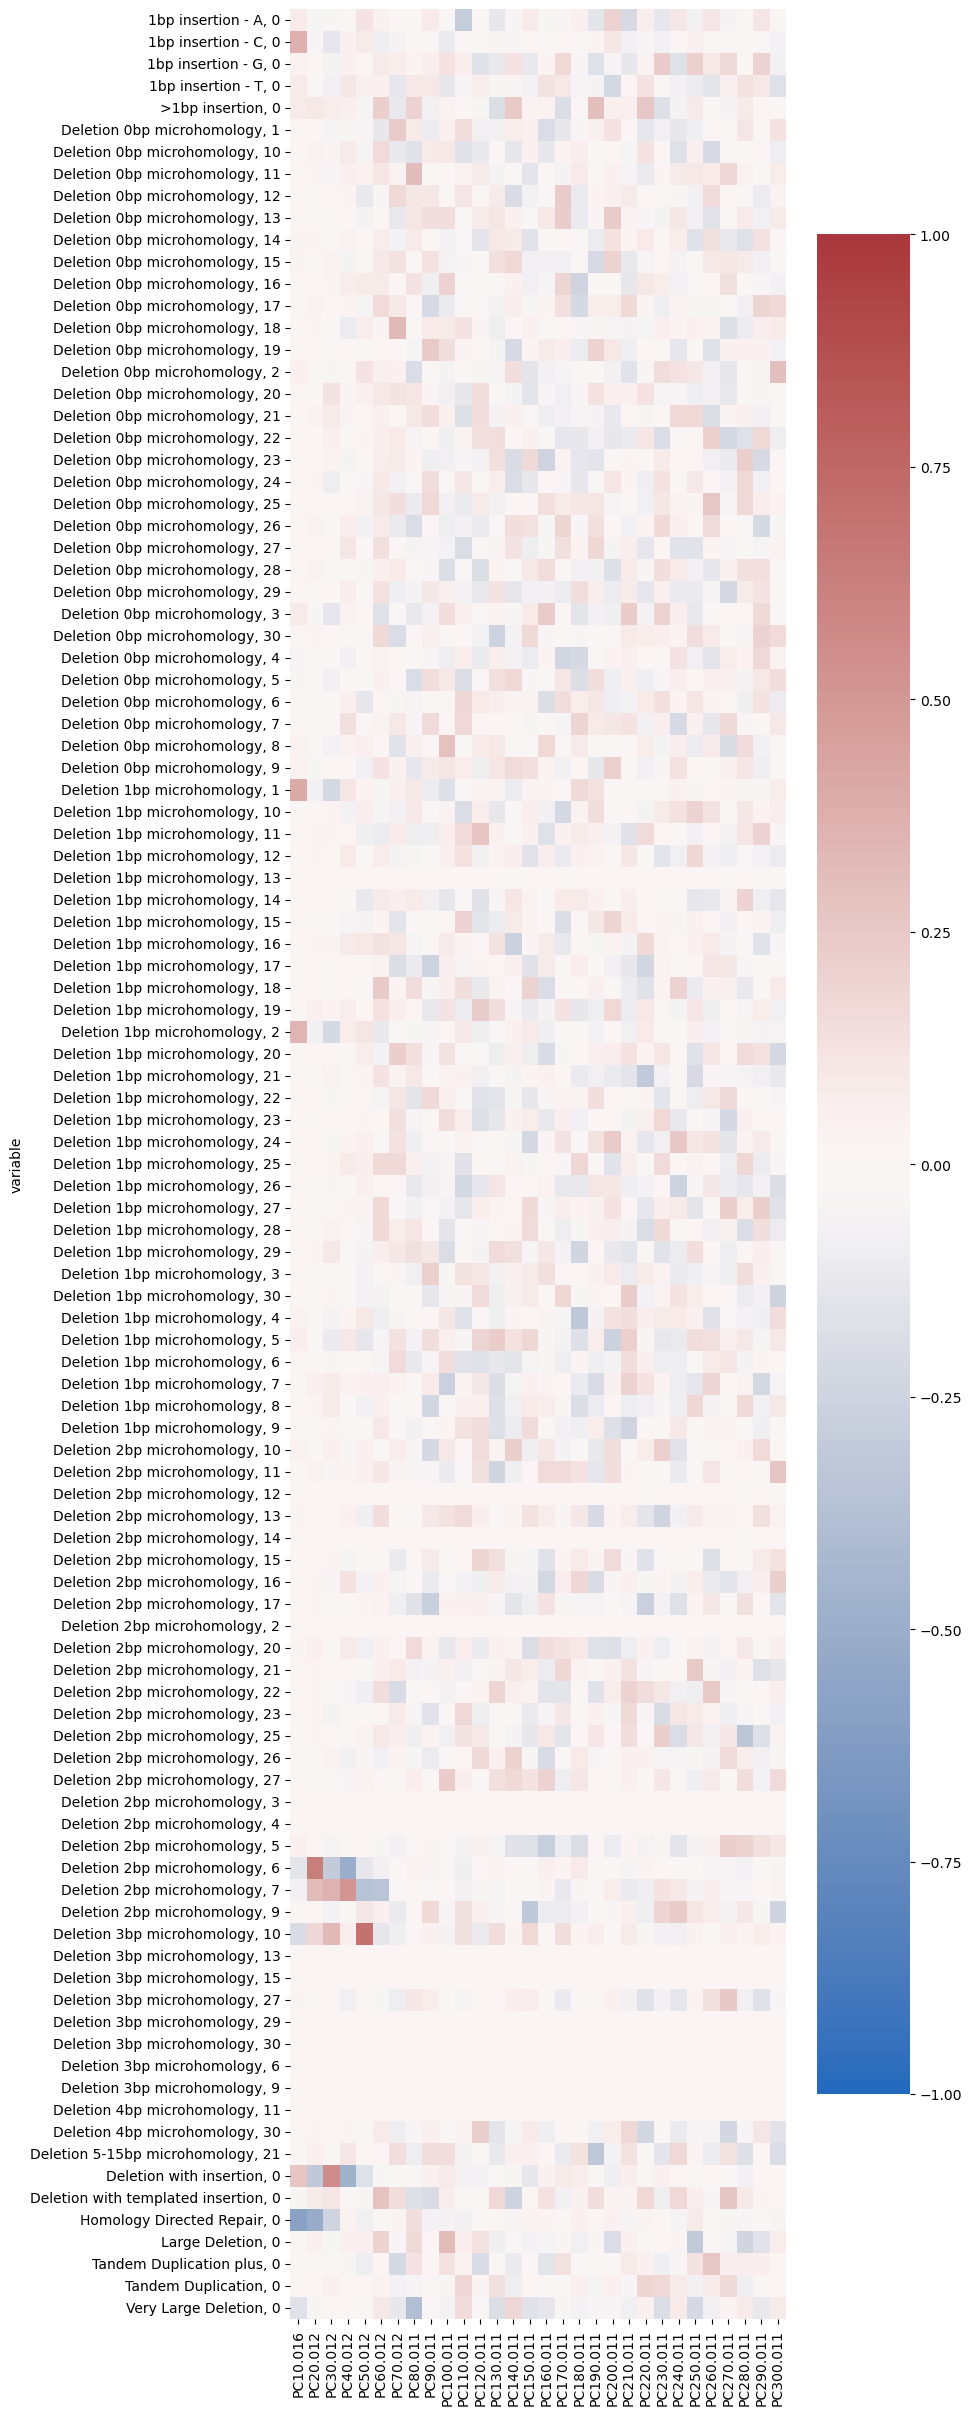

In [117]:
plt.figure(figsize=(8, 30))
sns.heatmap(loadings_df.iloc[:,:30], center=0, vmin=-1, vmax=1, cmap="vlag")

In [118]:
from bioinfokit.visuz import cluster

# get 2D biplot
cluster.biplot(cscore=pca_scores[np.random.choice(pca_scores.shape[0], 10000, replace=False), :], loadings=loadings, labels=X.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(20,20), figtype="pdf")


In [119]:

# cluster.pcaplot(x=loadings[0], y=loadings[1], labels=X.columns.values, 
#     var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
#     var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(30,30), figtype="pdf")

In [120]:
# calculate mahalanobis distance chapter 3.3.1 of outlier analysis second version
from scipy.stats import chi2

mahal_df = pd.DataFrame({"mahal_dist": np.sum(np.square(pca_df).values, axis=1)}, index=X.index)  
mahal_df['p'] = 1 - chi2.cdf(mahal_df['mahal_dist'], pca_df.shape[1] - 1)

In [121]:
from sklearn.neighbors import NearestNeighbors

k = 10

knn = NearestNeighbors(n_neighbors=k)

knn.fit(pca_df.values)

neighbors_and_distances = knn.kneighbors(pca_df.values)
knn_distances = neighbors_and_distances[0]
tnn_distance = np.mean(knn_distances, axis=1)

In [122]:
mahal_df["nn_dist"] = tnn_distance

In [123]:
mahal_df.xs("Fanca", level="Gene")

mahal_dist         p   nn_dist
Alias Barcode                                
MB03  Fanca-1   41.602844  1.000000  5.331970
      Fanca-2   58.106550  0.999921  6.346126
      Fanca-3   45.575227  1.000000  5.706383
      Fanca-4   24.486844  1.000000  4.525246
      Fanca-5   65.281754  0.998925  6.715493
MB04  Fanca-1   59.160455  0.999879  6.211408
      Fanca-2   50.762761  0.999998  5.937295
      Fanca-3   68.979095  0.996771  6.838082
      Fanca-4   21.346767  1.000000  4.184553
      Fanca-5   78.024870  0.973212  7.226471

In [124]:
# need to do FDR correction with multiple hypothesis testing

from statsmodels.stats.multitest import fdrcorrection
fdr_results = fdrcorrection(mahal_df['p'], alpha=0.05)
mahal_df["rejected"] = fdr_results[0]
mahal_df["p_corrected"] = fdr_results[1]


In [125]:
from src.config import get_interim_dir


mahal_df.to_csv(get_interim_dir() + "{}_mahalanobis_dist_outliers.txt".format(target_site_to_test), sep="\t")

In [126]:
import pickle

# need to add code to save 
# profile matrix
# pca object
# outlier analysis
# for each target site for further analysis

pca_analysis = {
    "X": X,
    "scaler": scaler,
    "pca_out": pca_out,
    "outliers": mahal_df
}

pickle.dump(pca_analysis, open(get_interim_dir() + "pca_analysis_{}.pkl".format(target_site_to_test), 'wb'))


# Do analysis and write up notes